# Classification


## importing packages



In [14]:
import pandas as pd
import numpy as np
from datetime import datetime, date
from datetime import timedelta
import matplotlib.pyplot as plt
import itertools

# Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Preprocessing:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest

# crossvalidation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# evaluation:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report

## Set up functions

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Data Preparation and Split

In [22]:
data = pd.read_csv("../data/processed/all_features_and_target_variabes.csv")

# OneHotEncoding:
data["format_nan"] = pd.Series(data["format"]!=data["format"], dtype=int)
data["format_harvmac"] = pd.Series(data["format"]=="harvmac", dtype=int)
data["format_latex"] = pd.Series(data["format"]=="latex", dtype=int)
data["format_plain_tex"] = pd.Series(data["format"]=="plain tex", dtype=int)
data["format_latexlatex"] = pd.Series(data["format"]=="latex,latex", dtype=int)

# load G to get dates:
import sys
from os.path import join, dirname
from os import pardir
sys.path.insert(1, join(pardir, "src", "data"))
sys.path.insert(1, join(pardir, pardir, "data", "processed"))
from graphio import read_graph
G = read_graph("hep-th-citations_unzipped.txt", "hep-th-slacdates_unzipped.txt")

# remove last_year:
last_date = date(2003, 5, 1)
delta = timedelta(days=365)
data["not_last_year"] = data["paper_id"].apply(lambda x: G.nodes[x]["time"] <= last_date - delta)
data = data[data["not_last_year"]]


# drop rows with target = NaN
data = data[data["label"]==data["label"]]

# replace NaN in journal_counts with 0:
data.loc[(data["journal_counts"]>=0)==False, "journal_counts"]=0
# replace NaN with 10 for num_of_pages
data.loc[data["num_of_pages"]!=data["num_of_pages"], "num_of_pages"] = 10
# replace NaN with 0
data.loc[data["recency_of_cited_papers_avg"]!=data["recency_of_cited_papers_avg"], "recency_of_cited_papers_avg"] = 0
data.loc[data["max_time_difference_bw_cited_papers"]!=data["max_time_difference_bw_cited_papers"], "max_time_difference_bw_cited_papers"] = 0


# split in train and test
data["is_train"] = data["paper_id"].apply(lambda x: G.nodes[x]["time"] <= last_date - 2*delta)
data["is_test"] = data["paper_id"].apply(lambda x: G.nodes[x]["time"] > last_date - 2*delta)
data_train = data[data["is_train"]]
data_test = data[data["is_test"]]

target_train = data_train["label"]
target_test = data_test["label"]
features = ['indegrees_of_cited_papers_sum',
       'indegrees_of_cited_papers_avg', 'recency_of_cited_papers_avg',
       'max_time_difference_bw_cited_papers', 'outdegree',
       'outdegrees_of_cited_papers_sum', 'outdegrees_of_cited_papers_avg',
       'num_of_pages',
       'format_nan', 'format_harvmac', 'format_latex', 'format_plain_tex',
       'format_latexlatex', 'journal_counts']
data_train = data_train[features]
data_test = data_test[features]



loading Graph...
delete future citations...
Graph loaded.


In [23]:
data_train.head(10)

,indegrees_of_cited_papers_sum,indegrees_of_cited_papers_avg,recency_of_cited_papers_avg,max_time_difference_bw_cited_papers,outdegree,outdegrees_of_cited_papers_sum,outdegrees_of_cited_papers_avg,num_of_pages,format_nan,format_harvmac,format_latex,format_plain_tex,format_latexlatex,journal_counts
0,317,31.700000,523.000000,947.0,10,99,9.900000,15.0,1,0,0,0,0,13.0
1,175,19.444444,146.333333,448.0,9,86,9.555556,13.0,0,1,0,0,0,8.0
2,39,6.500000,705.000000,959.0,6,11,1.833333,16.0,0,0,1,0,0,5.0
3,222,20.181818,273.272727,909.0,11,116,10.545455,10.0,0,0,1,0,0,0.0
4,14,4.666667,357.333333,459.0,3,10,3.333333,1.0,0,0,1,0,0,31.0
5,11,2.750000,734.250000,630.0,4,4,1.000000,6.0,0,0,1,0,0,0.0
6,39,3.250000,840.916667,882.0,12,54,4.500000,21.0,0,0,1,0,0,102.0
7,262,18.714286,618.714286,1236.0,14,62,4.428571,10.0,0,0,1,0,0,21.0
8,31,4.428571,648.000000,861.0,7,11,1.571429,12.0,0,0,1,0,0,2.0
9,32,10.666667,782.000000,644.0,3,12,4.000000,105.0,0,0,1,0,0,0.0


# Decision Tree Classifier


In [24]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

class_weight = {0: 5044, 1: 9509, 2: 1103, 3: 840}
gridsearch_parameters = [{'classification': (DecisionTreeClassifier(class_weight=class_weight),),
                        'classification__min_samples_split': (5, 10, 15),
                        'classification__criterion': ('gini', 'entropy'),
                        'classification__max_depth': (None, 4, 7),
                        'feature_selection__k': ('all', 6, 10, 13)}]
pipeline = Pipeline([("scaler", StandardScaler()), ("feature_selection", SelectKBest(k="all")), ("classification", DecisionTreeClassifier())])



grid_search_estimator = GridSearchCV(pipeline, gridsearch_parameters, scoring='f1_macro',cv=cv, return_train_score=True)

grid_search_estimator.fit(data_train, target_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('feature_selection',
                                        SelectKBest(k='all')),
                                       ('classification',
                                        DecisionTreeClassifier())]),
             param_grid=[{'classification': (DecisionTreeClassifier(class_weight={0: 5044,
                                                                                  1: 9509,
                                                                                  2: 1103,
                                                                                  3: 840},
                                                                    criterion='entropy',
                                                                    min_samples_split=5),),
                          'classification__criterion': ('gi

Best parameters: 
classification : DecisionTreeClassifier(class_weight={0: 5044, 1: 9509, 2: 1103, 3: 840},
                       criterion='entropy', min_samples_split=5)
classification__criterion : entropy
classification__max_depth : None
classification__min_samples_split : 5
feature_selection__k : 13

Mean Train Scores:
 [0.84426941 0.72970216 0.83351267 0.84354252 0.71283665 0.57906216
 0.70677252 0.71256869 0.6394638  0.50174048 0.63547962 0.63882954
 0.21778765 0.18412446 0.21374665 0.21778765 0.21778765 0.18412446
 0.21374665 0.21778765 0.21778765 0.18412201 0.21374665 0.21778765
 0.27410431 0.20420424 0.26751942 0.27419204 0.27364982 0.2033376
 0.26703276 0.2735621  0.27227189 0.20255177 0.2660215  0.27227189
 0.87581609 0.76863911 0.86697675 0.8753115  0.72420045 0.59753315
 0.71278504 0.72481566 0.62951595 0.51024299 0.62296623 0.63028811
 0.19340175 0.18239071 0.19340175 0.19340175 0.19340175 0.18239071
 0.19340175 0.19340175 0.19340175 0.18239071 0.19340175 0.19340175
 0.2

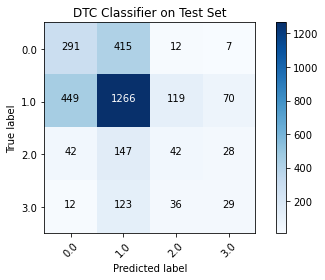

In [25]:
print("Best parameters: ")
for a,b in grid_search_estimator.best_params_.items():
    print(a , ":", b)
print()

print("Mean Train Scores:\n", grid_search_estimator.cv_results_['mean_train_score'])
print("Mean Test Scores:\n", grid_search_estimator.cv_results_['mean_test_score'])
print()

prediction = grid_search_estimator.predict(data_test)
cm = confusion_matrix(target_test, prediction)
plot_confusion_matrix(cm, classes = unique_labels(target_test), title = "DTC Classifier on Test Set")
print(classification_report(target_test, prediction))

# GradientBoostingClassifier

In [28]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

class_weight = {0: 5044, 1: 9509, 2: 1103, 3: 840}
# Note: there is no class_weight possibility for Gradient Boosting Classifier
gridsearch_parameters = [{'classification': (GradientBoostingClassifier(),),#class_weight=class_weight),),
                        'classification__min_samples_split': (5, 10, 15),
                        'classification__criterion': ('friedman_mse', 'squared_error', 'mse'),
                        'classification__max_depth': (None, 4, 7),
                        'feature_selection__k': ('all', 6, 10, 13)}]
pipeline = Pipeline([("scaler", StandardScaler()), ("feature_selection", SelectKBest(k="all")), ("classification", None)])



grid_search_estimator = GridSearchCV(pipeline, gridsearch_parameters, scoring='f1_macro',cv=cv, return_train_score=True)

grid_search_estimator.fit(data_train, target_train)

C:\Users\Win10\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 504, in fit
    n_stages = self._fit_stages(
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 561, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 214, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  F

C:\Users\Win10\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 504, in fit
    n_stages = self._fit_stages(
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 561, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 214, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  F

C:\Users\Win10\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 504, in fit
    n_stages = self._fit_stages(
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 561, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 214, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  F

C:\Users\Win10\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 504, in fit
    n_stages = self._fit_stages(
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 561, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 214, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  F

C:\Users\Win10\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 504, in fit
    n_stages = self._fit_stages(
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 561, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 214, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  F

C:\Users\Win10\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 504, in fit
    n_stages = self._fit_stages(
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 561, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 214, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  F

C:\Users\Win10\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 504, in fit
    n_stages = self._fit_stages(
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 561, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 214, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  F

C:\Users\Win10\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 504, in fit
    n_stages = self._fit_stages(
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 561, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 214, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  F

C:\Users\Win10\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 504, in fit
    n_stages = self._fit_stages(
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 561, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 214, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  F

C:\Users\Win10\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 504, in fit
    n_stages = self._fit_stages(
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 561, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 214, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  F

C:\Users\Win10\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 504, in fit
    n_stages = self._fit_stages(
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 561, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 214, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  F

C:\Users\Win10\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 504, in fit
    n_stages = self._fit_stages(
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 561, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 214, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  F

C:\Users\Win10\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 504, in fit
    n_stages = self._fit_stages(
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 561, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 214, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  F

C:\Users\Win10\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 504, in fit
    n_stages = self._fit_stages(
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 561, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 214, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  F

C:\Users\Win10\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 504, in fit
    n_stages = self._fit_stages(
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 561, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 214, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  F

C:\Users\Win10\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 504, in fit
    n_stages = self._fit_stages(
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 561, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 214, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  F

C:\Users\Win10\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 504, in fit
    n_stages = self._fit_stages(
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 561, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 214, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  F

C:\Users\Win10\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 504, in fit
    n_stages = self._fit_stages(
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 561, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\Win10\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 214, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  F

C:\Users\Win10\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.41198562 0.35173983 0.40180666 0.40790206 0.41166291 0.34743756
 0.40803288 0.41303434 0.40971476 0.35236675 0.40999302 0.41243577
 0.40911886 0.33291443 0.40888831 0.40806014 0.40909269 0.33196086
 0.4069591  0.40820648 0.40683013 0.33450318 0.40654989 0.40912242
 0.41236613 0.34010953 0.41029001 0.40837939 0.40914021 0.33999788
 0.40903868 0.408022   0.41201724 0.33832201 0.40871306 0.41238604
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.40964302 0.34614601 0.41215673 0.40740743 0.413868

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('feature_selection',
                                        SelectKBest(k='all')),
                                       ('classification', None)]),
             param_grid=[{'classification': (GradientBoostingClassifier(criterion='mse',
                                                                        max_depth=7,
                                                                        min_samples_split=5),),
                          'classification__criterion': ('friedman_mse',
                                                        'squared_error',
                                                        'mse'),
                          'classification__max_depth': (None, 4, 7),
                          'classification__min_samples_split': (5, 10, 15),
                          'feature_selec

Best parameters: 
classification : GradientBoostingClassifier(criterion='mse', max_depth=7, min_samples_split=5)
classification__criterion : mse
classification__max_depth : 7
classification__min_samples_split : 5
feature_selection__k : 10

Mean Train Scores:
 [0.98790205 0.93524098 0.97967577 0.9879009  0.98789895 0.93528702
 0.97970609 0.98788754 0.98786291 0.93530082 0.979711   0.98786834
 0.56046878 0.44785481 0.55207599 0.55889532 0.5571676  0.44447861
 0.55025325 0.55678608 0.55195516 0.439375   0.54816071 0.55516223
 0.84271981 0.71857609 0.83575903 0.84136646 0.83151548 0.68906465
 0.81969892 0.8294181  0.81422553 0.66965441 0.80662632 0.81712617
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
   

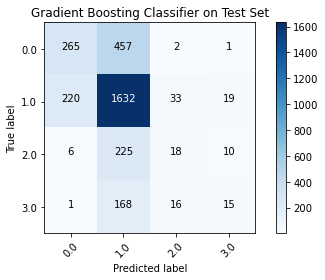

In [30]:
print("Best parameters: ")
for a,b in grid_search_estimator.best_params_.items():
    print(a , ":", b)
print()

print("Mean Train Scores:\n", grid_search_estimator.cv_results_['mean_train_score'])
print("Mean Test Scores:\n", grid_search_estimator.cv_results_['mean_test_score'])
print()

prediction = grid_search_estimator.predict(data_test)
cm = confusion_matrix(target_test, prediction)
plot_confusion_matrix(cm, classes = unique_labels(target_test), title = "Gradient Boosting Classifier on Test Set")
print(classification_report(target_test, prediction))

# SVM

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

class_weight = {0: 5044, 1: 9509, 2: 1103, 3: 840}
gridsearch_parameters = [{'classification': (SVC(class_weight=class_weight),),
                        'classification__kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
                        'classification__max_iter': (-1, 50, 150),
                        'feature_selection__k': ('all', 6, 10, 13)}]
pipeline = Pipeline([("scaler", StandardScaler()), ("feature_selection", SelectKBest(k="all")), ("classification", None)])



grid_search_estimator = GridSearchCV(pipeline, gridsearch_parameters, scoring='f1_macro',cv=cv, return_train_score=True)

grid_search_estimator.fit(data_train, target_train)

In [ ]:
print("Best parameters: ")
for a,b in grid_search_estimator.best_params_.items():
    print(a , ":", b)
print()

print("Mean Train Scores:\n", grid_search_estimator.cv_results_['mean_train_score'])
print("Mean Test Scores:\n", grid_search_estimator.cv_results_['mean_test_score'])
print()

prediction = grid_search_estimator.predict(data_test)
cm = confusion_matrix(target_test, prediction)
plot_confusion_matrix(cm, classes = unique_labels(target_test), title = "SVC on Test Set")
print(classification_report(target_test, prediction))

# Random Forest Classifier

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

class_weight = {0: 5044, 1: 9509, 2: 1103, 3: 840}
gridsearch_parameters = [{'classification': (GradientBoostingClassifier(class_weight=class_weight),),
                        'classification__min_samples_leaf': (5, 10, 15),
                        'classification__n_estimators': (50, 100, 150),
                        'classification__max_depth': (None, 4, 7),
                        'criterion': ('gini', 'entropy'),
                        'feature_selection__k': ('all', 6, 10, 13)}]
pipeline = Pipeline([("scaler", StandardScaler()), ("feature_selection", SelectKBest(k="all")), ("classification", None)])



grid_search_estimator = GridSearchCV(pipeline, gridsearch_parameters, scoring='f1_macro',cv=cv, return_train_score=True)

grid_search_estimator.fit(data_train, target_train)

In [ ]:
print("Best parameters: ")
for a,b in grid_search_estimator.best_params_.items():
    print(a , ":", b)
print()

print("Mean Train Scores:\n", grid_search_estimator.cv_results_['mean_train_score'])
print("Mean Test Scores:\n", grid_search_estimator.cv_results_['mean_test_score'])
print()

prediction = grid_search_estimator.predict(data_test)
cm = confusion_matrix(target_test, prediction)
plot_confusion_matrix(cm, classes = unique_labels(target_test), title = "Random Forest Classifier on Test Set")
print(classification_report(target_test, prediction))